# Here, we will be performing a grid search to look for the best hyperparameters for our model.


### We will set up our project much like in the previous notebook, but we will will cycle through different regression models and hyperparameters to find the best model for our data.

In [5]:
import numpy as np
import pandas as pd
import sys
import os 
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
import glob

from sglm import utils, glm_fit, predictor_labels
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet, Ridge, LinearRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create a project

#### First, let's create a new project. The project directory will create a data and results folder and a config file.

#### You will need to edit the config file with the particular glm params you wish to use. Fields that are necessary to edit are: predictors, predictors_shift_bounds, response, and the glm_keyword_args.

#### You will also need to move your data into the data folder.

In [6]:
#set data path
workingDirectory = os.getcwd()
dataFolder = 'projects/bestParamSearch'
workingPath = os.path.join(workingDirectory, dataFolder)
print(workingPath)

e:\Emily\sabatini-glm-workflow\projects/bestParamSearch


In [7]:
project_name = 'FoxP2_combinedCatchx4_Lhemi_paramSearch'
project_dir = workingPath

utils.create_new_project(project_name, project_dir)

Project directory already exists!


'e:\\Emily\\sabatini-glm-workflow\\projects/bestParamSearch\\FoxP2_combinedCatchx4_Lhemi_paramSearch\\config.yaml'

In [8]:
#set analysis parameters in the config file

#first day predictors
#predictor_list = ['go','nogo','lick_1R','lick_1','lick_2','lick_3','last_lick','lick_non1-3','missReward']

#catch day predictors
predictor_list = ['go','nogo','lick_1','lick_2','lick_3','lick_3R','lick_3C','last_lick','lick_non1-3','missReward','freeReward']

#set predictors temp for leave one out analysis later in script
#first day predictors
#predictors_temp=['nogo', 'lick_1','last_lick', 'lick_non1-3']

#catch day predictors
predictors_temp=['nogo', 'lick_3', 'lick_3C', 'last_lick', 'lick_non1-3']

predictors_shift_bounds_list = [-50, 100]
response = 'photometryLhemi'

In [9]:
project_path = os.path.join(project_dir, project_name)
files = os.listdir(project_path)

assert 'data' in files, 'data folder not found! {}'.format(files)
assert 'results' in files, 'results folder not found! {}'.format(files)
assert 'config.yaml' in files, 'config.yaml not found! {}'.format(files)

In [10]:
config_file = os.path.join(project_path, 'config.yaml')
config = utils.load_config(config_file)

# Import and Format Data

Input data should conform to the following convention and be saved as a *.csv:

Indices / Unique Row Identifiers:
* SessionName -- Any order is acceptable
* TrialNumber-- Must be in chronological order, but does not need to start from zero
* Timestamp -- Must be in chronological order, but does not need to start from zero

Columns (Predictors + Responses):
* Predictors - binary
* Reponses - e.g. neural responses (analog or binary)

Example, shown below is dummy data depicting a trial_0 that last four response timestamps:
| SessionName | TrialNumber | Timestamp | predictor_1 | predictor_2 | predictor_3 | response_1 | response_2 |
| --- | --- | --- | --- | --- | --- | --- | --- |
| session_0 | trial_0 | -1 | 0 | 0 | 0 | 1 | 0.3 |
| session_0 | trial_0 | 0 | 0 | 0 | 0 | 0 | 1.4 |
| session_0 | trial_0 | 1 | 0 | 0 | 0 | 1 | 2.3 |
| session_0 | trial_0 | 2 | 0 | 1 | 0 | 1 | 0.3 |
| session_0 | trial_1 | -2 | 0 | 0 | 0 | 0 | 1.4 |
| session_0 | trial_1 | -1 | 0 | 0 | 0 | 1 | 2.3 |
| session_0 | trial_1 | 0 | 1 | 0 | 0 | 0 | 1.4 |
| session_0 | trial_1 | 1 | 0 | 0 | 0 | 1 | 2.3 |
| session_1 | trial_0 | 5 | 0 | 0 | 0 | 0 | 1.4 |
| session_1 | trial_0 | 6 | 1 | 0 | 0 | 1 | 2.3 |
| session_1 | trial_0 | 7 | 0 | 0 | 0 | 0 | 1.4 |
| session_1 | trial_0 | 8 | 0 | 0 | 0 | 1 | 2.3 |
| session_1 | trial_1 | 9 | 0 | 0 | 0 | 0 | 1.4 |
| session_1 | trial_1 | 10 | 0 | 0 | 0 | 1 | 2.3 |
....

#### If needed, use the following function to combine multiple sessions into one csv. You will need a filename you wish to call your output_csv

In [11]:
output_csv = 'combined.csv'

utils.combine_csvs(project_path, output_csv)

Combined 8 CSV files into combined.csv


'e:\\Emily\\sabatini-glm-workflow\\projects/bestParamSearch\\FoxP2_combinedCatchx4_Lhemi_paramSearch\\data\\combined.csv'

#### Next, we'll load the data and set the columns you wish to use as fixed indices. Following this step, you can explore and add features/predictors to the dataframe as needed.

In [12]:
input_file = os.path.join(project_path, 'data', output_csv)
index_col = ['SessionName', 'TrialNumber', 'Timestamp']

df = utils.read_data(input_file, index_col)

print('Your dataframe has {} rows and {} columns'.format(df.shape[0], df.shape[1]))

Your dataframe has 726412 rows and 7 columns


In [13]:
#Define predictor labels
df_source = predictor_labels.predictor_labels(df)
df_source

go  nogo  lick  reward outcome  \
SessionName       TrialNumber Timestamp                                   
20240521_AB154_g0 1           1           0     0     0       0      CR   
                              2           0     0     0       0      CR   
                              3           0     0     0       0      CR   
                              4           0     0     0       0      CR   
                              5           0     0     0       0      CR   
...                                      ..   ...   ...     ...     ...   
20240527_AB155_g0 252         103414      0     0     0       0       H   
                              103415      0     0     0       0       H   
                              103416      0     0     0       0       H   
                              103417      0     0     0       0       H   
                              103418      0     0     0       0       H   

                                         photometryLhemi  photometryRhemi  \
SessionName       TrialNumber Timestamp                                     
20240521_AB154_g0 1           1                -0.313964        -0.069778   
                              2                -0.470071        -0.690765   
                              3                -0.302880        -0.750383   
                              4                 0.161196        -0.656311   
                              5                -0.005425        -0.967946   
...                                                  ...              ...   
20240527_AB155_g0 252         103414            0.680236         0.087511   
                              103415            0.764608         0.018089   
                              103416            0.415593         1.018006   
                              103417            0.324174         0.130560   
                              103418            0.312678         0.639263   

                                         lick_1  lick_2  lick_3  ...  go_hit  \
SessionName       TrialNumber Timestamp                          ...           
20240521_AB154_g0 1           1               0       0       0  ...       0   
                              2               0       0       0  ...       0   
                              3               0       0       0  ...       0   
                              4               0       0       0  ...       0   
                              5               0       0       0  ...       0   
...                                         ...     ...     ...  ...     ...   
20240527_AB155_g0 252         103414          0       0       0  ...       0   
                              103415          0       0       0  ...       0   
                              103416          0       0       0  ...       0   
                              103417          0       0       0  ...       0   
                              103418          0       0       0  ...       0   

                                         go_miss  nogo_cr  nogo_fa  lick_1R  \
SessionName       TrialNumber Timestamp                                       
20240521_AB154_g0 1           1                0        0        0        0   
                              2                0        0        0        0   
                              3                0        0        0        0   
                              4                0        0        0        0   
                              5                0        0        0        0   
...                                          ...      ...      ...      ...   
20240527_AB155_g0 252         103414           0        0        0        0   
                              103415           0        0        0        0   
                              103416           0        0        0        0   
                              103417           0        0        0        0   
                              103418           0        0        0        

In [14]:
#Confirm that the unique trials are equal to the expected numbers
filtered_df = df_source[df_source['go']==1]
unique_trial_numbers = pd.unique(filtered_df.index.get_level_values('TrialNumber'))
unique_trial_numbers
print(len(unique_trial_numbers))
filtered_df

300


go  nogo  lick  reward outcome  \
SessionName       TrialNumber Timestamp                                   
20240521_AB154_g0 3           558         1     0     0       0      CR   
                  4           883         1     0     0       0       H   
                  5           1109        1     0     0       0       H   
                  6           1351        1     0     0       0       C   
                  8           1964        1     0     0       0      FR   
...                                      ..   ...   ...     ...     ...   
20240527_AB155_g0 243         99114       1     0     0       0       H   
                  245         100151      1     0     0       0       H   
                  246         100601      1     0     0       0       C   
                  249         102242      1     0     0       0       H   
                  252         103247      1     0     0       0       H   

                                         photometryLhemi  photometryRhemi  \
SessionName       TrialNumber Timestamp                                     
20240521_AB154_g0 3           558               0.119594        -0.390210   
                  4           883               0.024296        -0.672466   
                  5           1109              0.329309         0.803619   
                  6           1351             -0.739872        -0.616827   
                  8           1964             -0.576547        -1.108498   
...                                                  ...              ...   
20240527_AB155_g0 243         99114            -0.379915        -1.421932   
                  245         100151           -1.212488        -0.645795   
                  246         100601            0.966457        -1.182185   
                  249         102242           -0.579846        -1.506429   
                  252         103247            1.408730         1.746145   

                                         lick_1  lick_2  lick_3  ...  go_hit  \
SessionName       TrialNumber Timestamp                          ...           
20240521_AB154_g0 3           558             0       0       0  ...       0   
                  4           883             0       0       0  ...       1   
                  5           1109            0       0       0  ...       1   
                  6           1351            0       0       0  ...       0   
                  8           1964            0       0       0  ...       0   
...                                         ...     ...     ...  ...     ...   
20240527_AB155_g0 243         99114           0       0       0  ...       1   
                  245         100151          0       0       0  ...       1   
                  246         100601          0       0       0  ...       0   
                  249         102242          0       0       0  ...       1   
                  252         103247          0       0       0  ...       1   

                                         go_miss  nogo_cr  nogo_fa  lick_1R  \
SessionName       TrialNumber Timestamp                                       
20240521_AB154_g0 3           558              0        0        0        0   
                  4           883              0        0        0        0   
                  5           1109             0        0        0        0   
                  6           1351             0        0        0        0   
                  8           1964             0        0        0        0   
...                                          ...      ...      ...      ...   
20240527_AB155_g0 243         99114            0        0        0        0   
                  245         100151           0        0        0        0   
                  246         100601           0        0        0        0   
                  249         102242           0        0        0        0   
                  252         103247           0        0        0        

#### Shift responses and predictors. If you do not want to shift your predictors by an amount you set, feel free to comment out the entire "predictors_shift_bounds" in config.yaml. We will then use the default set when we created the config file. 

#### For, larger datasets, you may want to sparse your training data. You can do this by seeting the sparsify argument to True in the shift_predcitors function.

In [15]:
# edit the predictors and shift bounds in the config file to the ones that I would like
config['glm_params']['predictors'] = predictor_list
config['glm_params']['predictors_shift_bounds_default'] = predictors_shift_bounds_list
config['glm_params']['response'] = response

# save back to config file
cfg_file = os.path.join(project_dir, project_path, "config.yaml")
utils.save_to_yaml(config, cfg_file)

'e:\\Emily\\sabatini-glm-workflow\\projects/bestParamSearch\\FoxP2_combinedCatchx4_Lhemi_paramSearch\\config.yaml'

In [16]:
#this is the shift operation - remember to use df_source (that has the predictors, rather than df)
response_shift, df_predictors_shift, shifted_params = glm_fit.shift_predictors(config, df_source, sparsify=True)
print('Your dataframe was shifted using: {}'.format(shifted_params))

Your dataframe was shifted using: [('go', [-50, 100]), ('nogo', [-50, 100]), ('lick_1', [-50, 100]), ('lick_2', [-50, 100]), ('lick_3', [-50, 100]), ('lick_3R', [-50, 100]), ('lick_3C', [-50, 100]), ('last_lick', [-50, 100]), ('lick_non1-3', [-50, 100]), ('missReward', [-50, 100]), ('freeReward', [-50, 100])]


In [17]:
X_train,X_test, y_train, y_test = glm_fit.split_data(df_predictors_shift, response_shift, config)

print('Training data has {} rows and {} columns'.format(X_train.shape[0], X_train.shape[1]))
print('Testing data has {} rows and {} columns'.format(X_test.shape[0], X_test.shape[1]))

Training data has 581129 rows and 1661 columns
Testing data has 145283 rows and 1661 columns


## Now, we will perform a grid search to find the best hyperparameters for our model. We will cycle through different regression models and hyperparameters to find the best model for our data. We will start with ElasticNet, Ridge, and OLS regression models.

In [18]:
pipeline = Pipeline([('regression', ElasticNet())])  # Start with ElasticNet as default

params_elasticnet = {
    'regression': [ElasticNet()],
    'regression__alpha': [0.0, 0.000001, 0.000005, 0.00001, 0.0001],  # Regularization strength, please edit.
    'regression__l1_ratio': [0.1, 0.5, 0.75, 1]  # Mixing parameter for ElasticNet, please edit.
}

# Define parameters for Ridge regression
params_ridge = {
    'regression': [Ridge()],
    'regression__alpha': [0.0, 0.000001, 0.000005, 0.00001, 0.0001] # Regularization strength, please edit.
}

params_OLS = {
    'regression': [LinearRegression()]
}

# Combine both parameter grids
params = [params_elasticnet, params_ridge, params_OLS]

# Add common parameters for GridSearchCV
common_params = {
    'estimator': pipeline,
    'param_grid': params,
    'cv': 5,
    'scoring': 'r2',  # r2, neg_mean_squared_error
    'refit': True,
    'n_jobs': -2,
    'verbose': 1,
    'return_train_score': True,
}

grid_reg = GridSearchCV(**common_params)
grid_reg.fit(X_train, y_train)

Fitting 5 folds for each of 26 candidates, totalling 130 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('regression', ElasticNet())]),
             n_jobs=-2,
             param_grid=[{'regression': [ElasticNet()],
                          'regression__alpha': [0.0, 1e-06, 5e-06, 1e-05,
                                                0.0001],
                          'regression__l1_ratio': [0.1, 0.5, 0.75, 1]},
                         {'regression': [Ridge()],
                          'regression__alpha': [0.0, 1e-06, 5e-06, 1e-05,
                                                0.0001]},
                         {'regression': [LinearRegression()]}],
             return_train_score=True, scoring='r2', verbose=1)

In [19]:
# Print best parameters and scores
print('Best parameters: {}'.format(grid_reg.best_params_))
print('Best cross-validated score: {:.2f}'.format(grid_reg.best_score_))
print('Test score: {:.2f}'.format(grid_reg.score(X_test, y_test)))
print('Refit time: {:.2f}'.format(grid_reg.refit_time_))

# Save best model and parameters
import pickle
model_path = config['Project']['project_path'] + '/models'
model_name = 'grid_search' + '_model.pkl'
model_full_path = os.path.join(model_path, model_name)
with open(model_full_path, 'wb') as f:
    pickle.dump(grid_reg, f)

Best parameters: {'regression': ElasticNet(), 'regression__alpha': 1e-05, 'regression__l1_ratio': 0.5}
Best cross-validated score: 0.27
Test score: 0.27
Refit time: 71.90


In [20]:
#for opening a saved model
#model_dict_path = r'C:\Users\janet\Dropbox (HMS)\processed_photometry\9010\9010_base\9010_base\models\grid_search_model.pkl'
#import pickle
#with open(model_dict_path, 'rb') as f:
#    grid_reg = pickle.load(f)

In [21]:
# dump the best paramaters to config file
regression_type = grid_reg.best_params_['regression'].__class__.__name__
alpha = grid_reg.best_params_['regression__alpha']

config['glm_params']['regression_type'] = regression_type
if regression_type == 'ElasticNet':
    l1_ratio = grid_reg.best_params_['regression__l1_ratio']
    config['glm_params']['glm_keyword_args']['elasticnet']['alpha'] = alpha
    config['glm_params']['glm_keyword_args']['elasticnet']['l1_ratio'] = l1_ratio
elif regression_type == 'Ridge':
    config['glm_params']['glm_keyword_args']['ridge']['alpha'] = alpha

# save back to config file
cfg_file = os.path.join(project_dir, project_path, "config.yaml")
utils.save_to_yaml(config, cfg_file)


'e:\\Emily\\sabatini-glm-workflow\\projects/bestParamSearch\\FoxP2_combinedCatchx4_Lhemi_paramSearch\\config.yaml'

In [22]:
#map the scores to the parameters
results = pd.DataFrame(grid_reg.cv_results_['params'])
results['mean_test_score'] = grid_reg.cv_results_['mean_test_score']
results['mean_train_score'] = grid_reg.cv_results_['mean_train_score']
results['std_test_score'] = grid_reg.cv_results_['std_test_score']
results['std_train_score'] = grid_reg.cv_results_['std_train_score']
results['rank_test_score'] = grid_reg.cv_results_['rank_test_score']
results['split0_test_score'] = grid_reg.cv_results_['split0_test_score']
results['split1_test_score'] = grid_reg.cv_results_['split1_test_score']
results['split2_test_score'] = grid_reg.cv_results_['split2_test_score']
results['split3_test_score'] = grid_reg.cv_results_['split3_test_score']
results['split4_test_score'] = grid_reg.cv_results_['split4_test_score']


results

,regression,regression__alpha,regression__l1_ratio,mean_test_score,mean_train_score,std_test_score,std_train_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,ElasticNet(),0.000000,0.10,0.270066,0.276527,0.003446,0.000859,14,0.275624,0.265927,0.270634,0.271200,0.266944
1,ElasticNet(),0.000000,0.50,0.270066,0.276527,0.003446,0.000859,14,0.275624,0.265927,0.270634,0.271200,0.266944
2,ElasticNet(),0.000000,0.75,0.270066,0.276527,0.003446,0.000859,14,0.275624,0.265927,0.270634,0.271200,0.266944
3,ElasticNet(),0.000000,1.00,0.270066,0.276527,0.003446,0.000859,14,0.275624,0.265927,0.270634,0.271200,0.266944
4,ElasticNet(),0.000001,0.10,0.270116,0.276525,0.003443,0.000859,12,0.275673,0.265984,0.270673,0.271254,0.266997
5,ElasticNet(),0.000001,0.50,0.270143,0.276522,0.003446,0.000859,11,0.275707,0.266009,0.270699,0.271277,0.267021
6,ElasticNet(),0.000001,0.75,0.270159,0.276518,0.003448,0.000859,10,0.275728,0.266025,0.270713,0.271292,0.267036
7,ElasticNet(),0.000001,1.00,0.270174,0.276514,0.003449,0.000859,9,0.275747,0.266042,0.270726,0.271306,0.267050
8,ElasticNet(),0.000005,0.10,0.270261,0.276483,0.003431,0.000859,8,0.275802,0.266152,0.270782,0.271415,0.267153
9,ElasticNet(),0.000005,0.50,0.270340,0.276413,0.003440,0.000859,6,0.275909,0.266233,0.270841,0.271495,0.267222


## Now we can run the recommended regression with the best parameters. 

In [23]:
model, y_pred, score, beta, intercept = glm_fit.fit_glm(config, X_train, X_test, y_train, y_test)

Fitting ElasticNet model...
Model fit complete


In [24]:
#Get the L2 term of the loss function
l2 = np.sum(beta**2)
print('The L2 term of the loss function is {}'.format(l2))

#compare it to the alpha term
print('The alpha term is {}'.format(alpha))

The L2 term of the loss function is 204.05672144537786
The alpha term is 1e-05


## Save your outputs

In [25]:
#Create your model dictonary, this should include all the information you wish to save
model_dict = {'model': model,
              'model_type': config['glm_params']['regression_type'],
              'y_pred': y_pred,
              'score': score,
              'beta': beta,
              'intercept': intercept,
              'l2': l2,
              }

#Save your model dictionary
glm_fit.save_model(model_dict, config)

#save model to text file
model_save_path = config['Project']['project_path'] + '/results/model_results'
with open(model_save_path, 'w') as f:
    print(model_dict, file = f)

model_dict

{'model': ElasticNet(alpha=1e-05),
 'model_type': 'ElasticNet',
 'y_pred': array([-0.35000162,  1.35463221, -0.24729816, ..., -0.0115663 ,
        -0.24729816, -0.1752695 ]),
 'score': 0.2727972271435052,
 'beta': array([ 0.02118973,  0.01249831,  0.04098168, ...,  0.        ,
        -0.08477367, -0.        ]),
 'intercept': -0.24729815605711847,
 'l2': 204.05672144537786}

In [26]:
#load your model dictionary if you already have it
import pickle
model_path = config['Project']['project_path'] + '/models'
model_name = project_name + '_model.pkl'
model_full_path = os.path.join(model_path, model_name)
with open(model_full_path, 'rb') as f:
    model_dict = pickle.load(f)

In [27]:
model = model_dict['model']
beta = model_dict['beta']

## Generate and save figures and results.
The following requires non-sparse data. If you have sparse data, you will need to re-run `shift_predictors` with the `sparse` argument set to `False`.

`plot_and_save` will save scatter plots of the predicted vs actual responses and the residuals and your beta coefficients. 

`plot_betas` will only *plot* the beta coefficients. 

`plot_aligned_dataStream` will plot the aligned data stream (e.g. aligned input data). You will need to run the `align_dataStream` function before running this plot.

`plot_actual_v_reconstructed` will plot the actual vs reconstructed responses. You will need to run the `align_reconstructed_dataStream` function before running this plot.

In [28]:
#first - you need to "desparsify" the data, in order to plot it - set sparsify back to false
response_shift, df_predictors_shift, shifted_params = glm_fit.shift_predictors(config, df_source, sparsify=False)
print('Your dataframe was shifted using: {}'.format(shifted_params))

Your dataframe was shifted using: [('go', [-50, 100]), ('nogo', [-50, 100]), ('lick_1', [-50, 100]), ('lick_2', [-50, 100]), ('lick_3', [-50, 100]), ('lick_3R', [-50, 100]), ('lick_3C', [-50, 100]), ('last_lick', [-50, 100]), ('lick_non1-3', [-50, 100]), ('missReward', [-50, 100]), ('freeReward', [-50, 100])]


In [29]:
X_train,X_test, y_train, y_test = glm_fit.split_data(df_predictors_shift, response_shift, config)

print('Training data has {} rows and {} columns'.format(X_train.shape[0], X_train.shape[1]))
print('Testing data has {} rows and {} columns'.format(X_test.shape[0], X_test.shape[1]))

Training data has 581129 rows and 1661 columns
Testing data has 145283 rows and 1661 columns


In [30]:
save_path = os.path.join(project_path, 'results')

In [31]:
glm_fit.plot_and_save(config, y_pred, y_test, beta, df_predictors_shift)

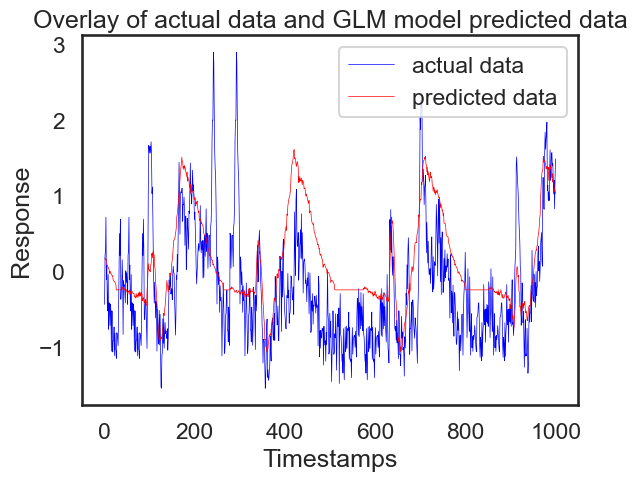

In [32]:
import matplotlib.pyplot as plt
import numpy as np

#retrieve predicted vs actual responses 
y_pred_all = model.predict(df_predictors_shift)
y_actual = response_shift
y_actual = y_actual.to_numpy()

#plot y_actual and y_pred on same graph for an example section of data
plt.plot(y_actual[13000:14000], color = 'b', lw = 0.5, label = 'actual data')
plt.plot(y_pred_all[13000:14000], color = 'r', lw = 0.5, label = 'predicted data')
plt.legend(loc="upper right")
plt.title("Overlay of actual data and GLM model predicted data")
plt.xlabel("Timestamps")
plt.ylabel("Response")

fig_save_path_png = os.path.join(project_dir, project_name, 'results\\overlay.png')
fig_save_path_pdf = os.path.join(project_dir, project_name, 'results\\overlay.pdf')
plt.savefig(fig_save_path_png)
plt.savefig(fig_save_path_pdf)

plt.show()

Directory created successfully!


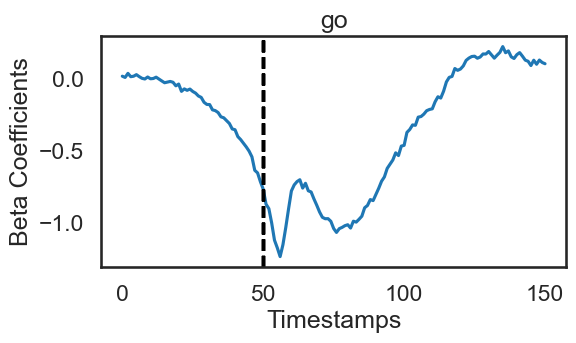

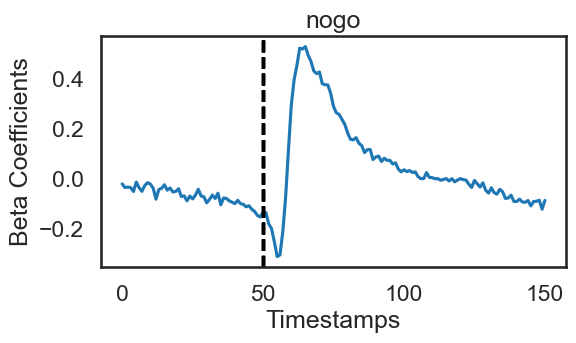

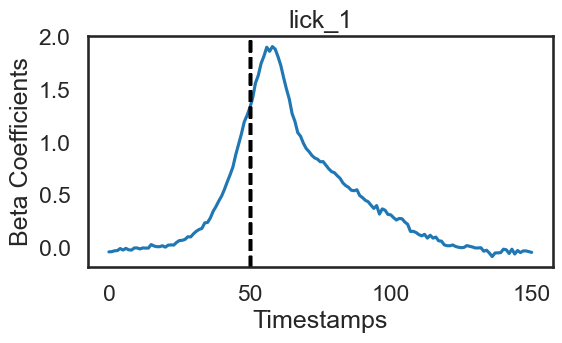

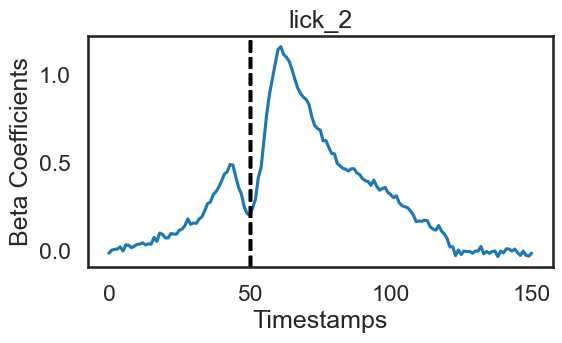

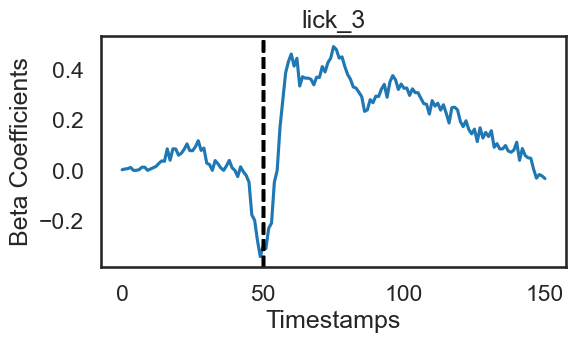

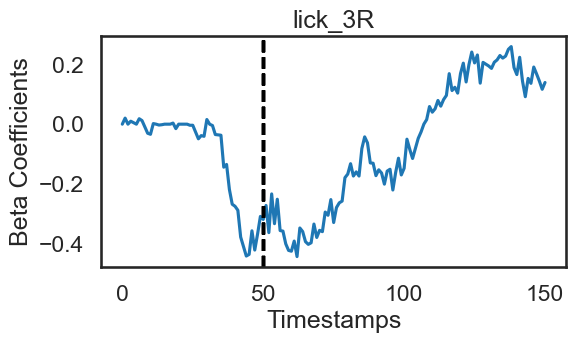

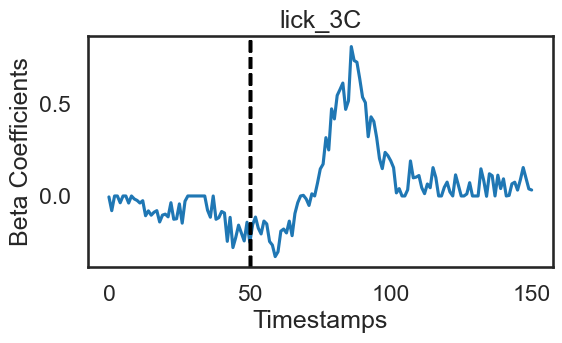

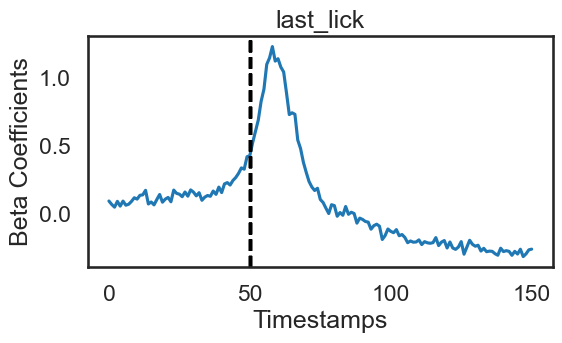

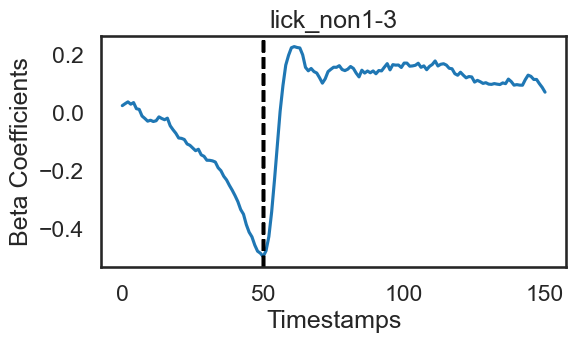

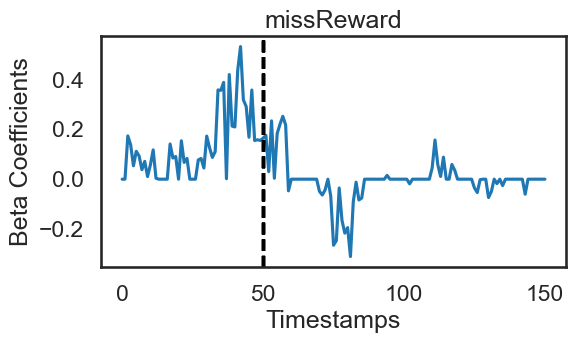

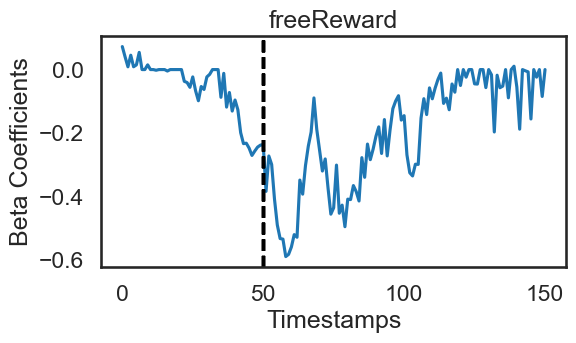

In [33]:
import shutil

# Create new directory for beta plots
save_dir = 'betas'
parent_dir = config['Project']['project_path'] + '/results/'
save_dir_path = os.path.join(parent_dir, save_dir)

# Check if the directory already exists
if not os.path.exists(save_dir_path):
    # Create the directory
    os.makedirs(save_dir_path)
    print("Directory created successfully!")
else:
    print("Directory already exists - will be overwritten!")
    #overwrite the directory
    shutil.copytree(save_dir_path, save_dir_path, dirs_exist_ok = True)
    
save_path = save_dir_path

utils.plot_betas(config, beta, df_predictors_shift, shifted_params, save=True, save_path=save_path)


### Align the data and plot the actual and reconstructed responses (e.g. predicted y) against the true responses (e.g. neural responses) for each prediction. 

100%|██████████| 55/55 [00:00<00:00, 1096.79it/s]


Directory created successfully!


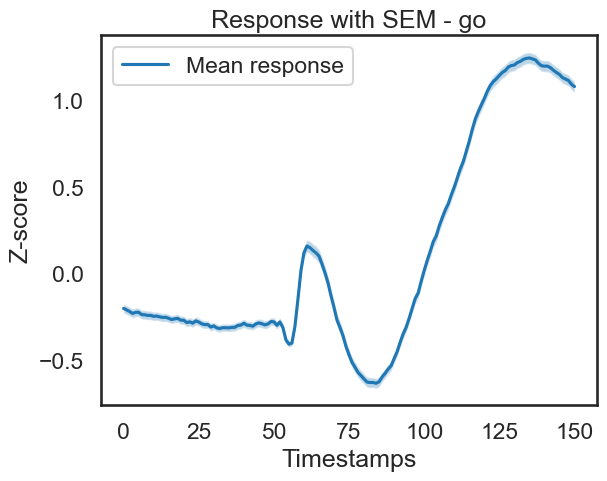

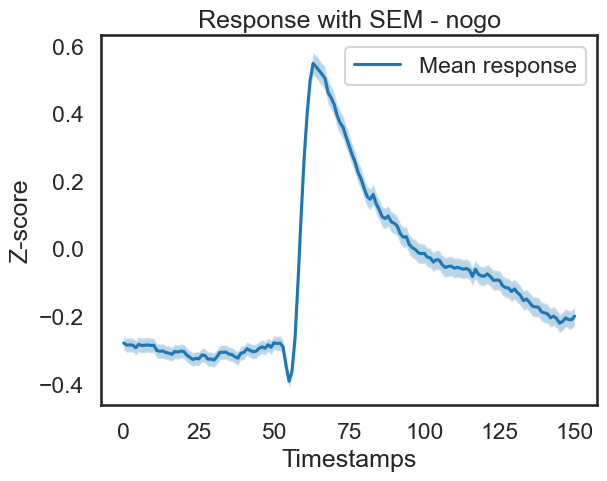

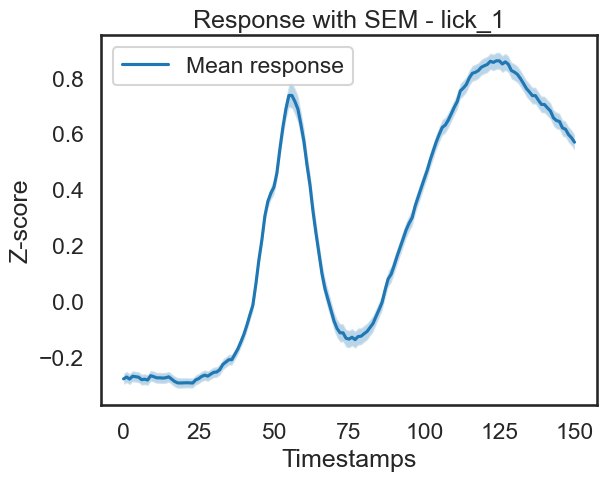

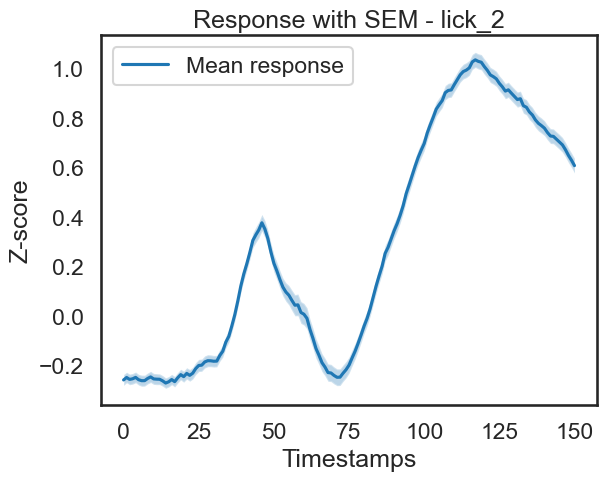

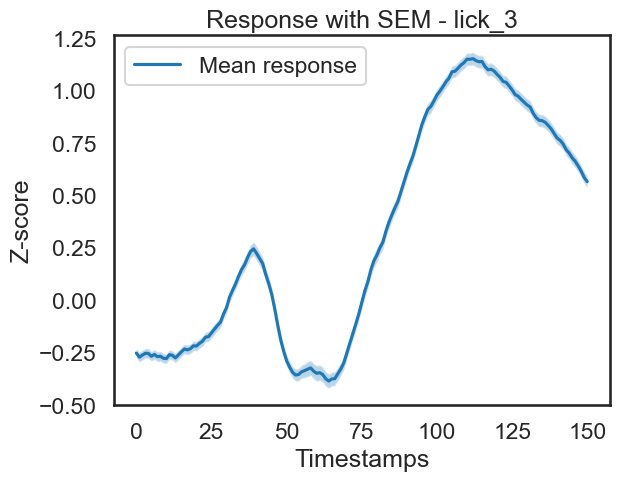

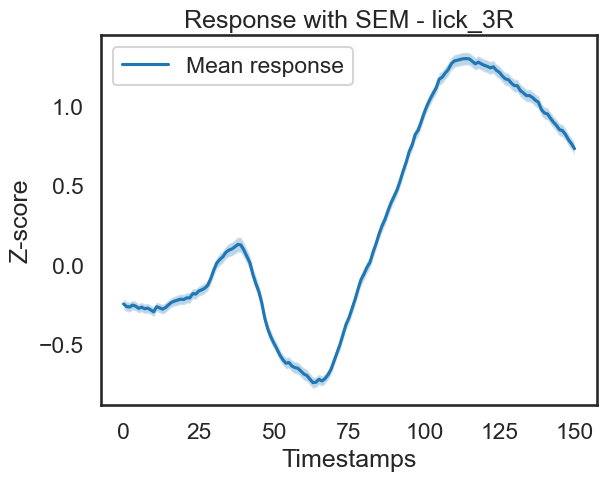

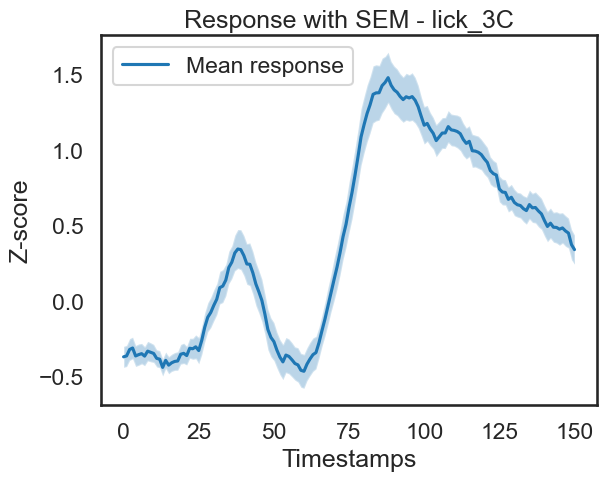

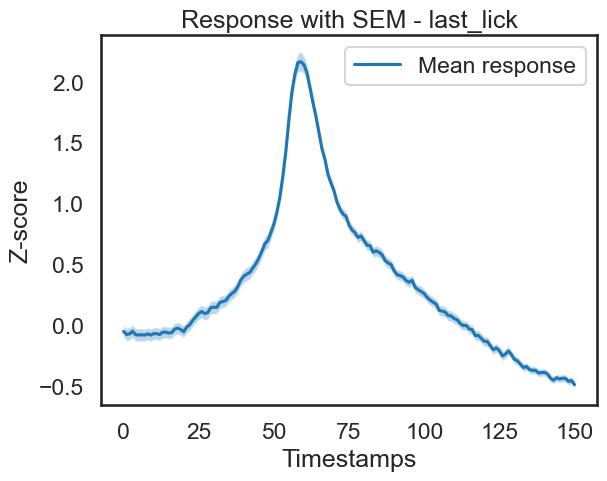

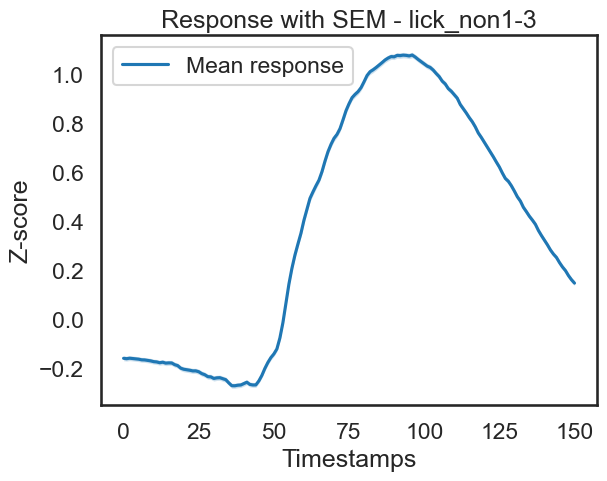

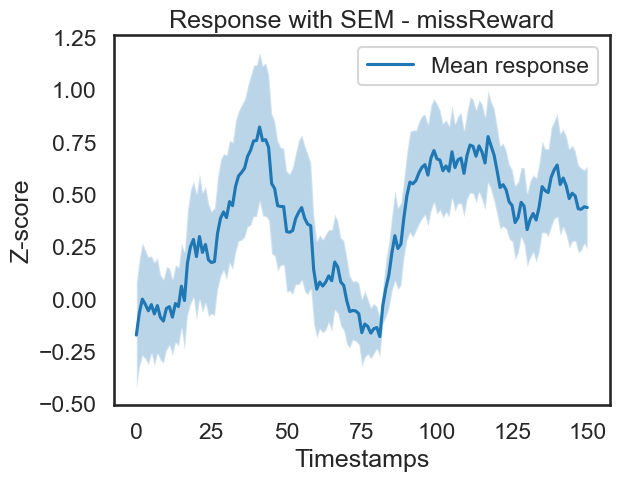

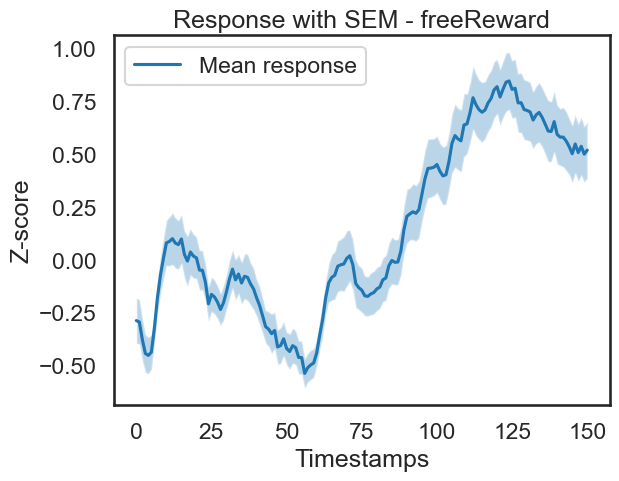

In [34]:
# Align your actual data
aligned_dataStream = utils.align_dataStream(config, df_source, shifted_params)

# Create new directory for aligned data plots
save_dir = 'aligned'
parent_dir = config['Project']['project_path'] + '/results/'
save_dir_path = os.path.join(parent_dir, save_dir)

# Check if the directory already exists
if not os.path.exists(save_dir_path):
    # Create the directory
    os.makedirs(save_dir_path)
    print("Directory created successfully!")
else:
    print("Directory already exists - will be overwritten!")
    #overwrite the directory
    shutil.copytree(save_dir_path, save_dir_path, dirs_exist_ok = True)

save_path = save_dir_path

# Plot aligned data
utils.plot_aligned_dataStream(aligned_dataStream, config, save=True, save_path=save_path, reconstructed=False)

100%|██████████| 55/55 [00:00<00:00, 1148.63it/s]


Directory created successfully!


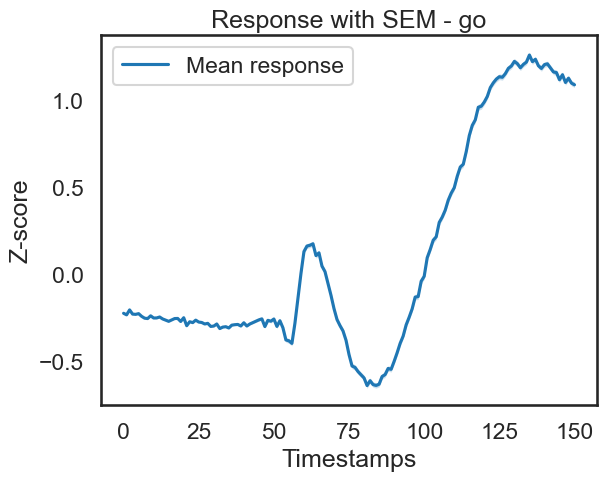

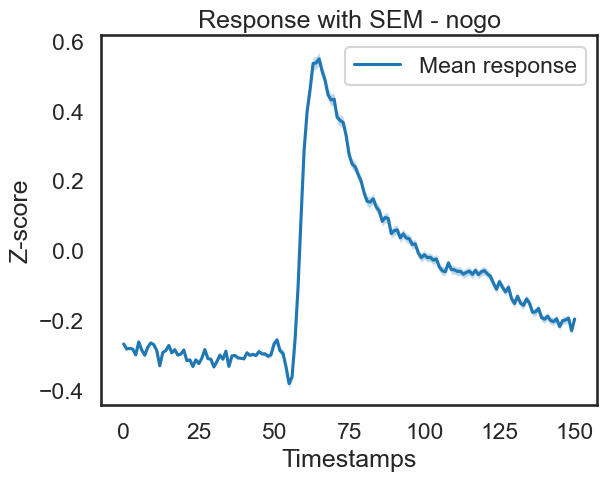

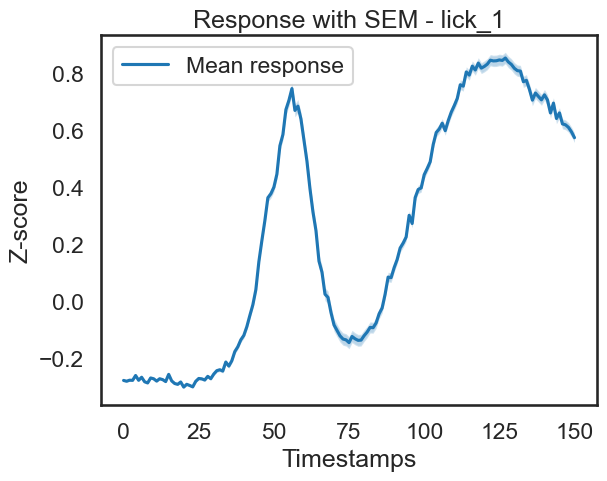

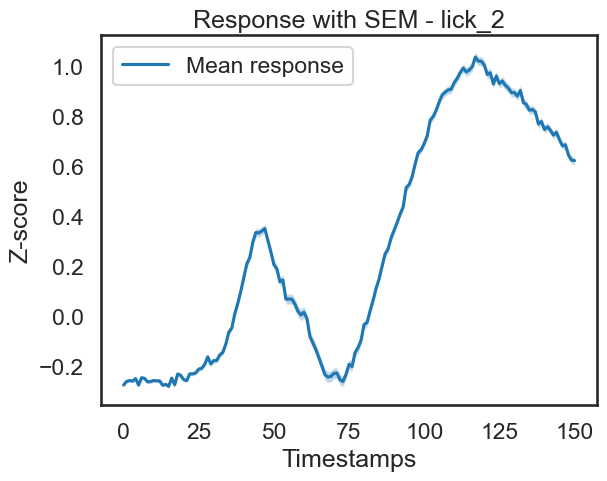

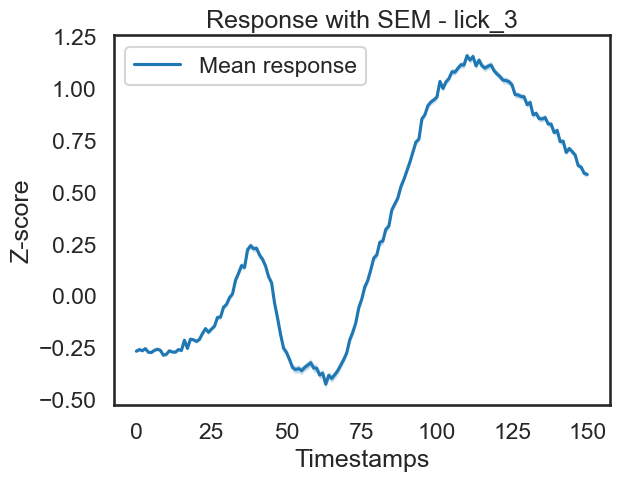

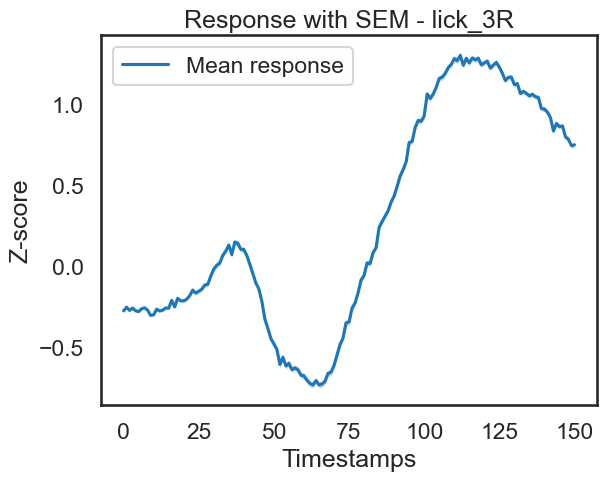

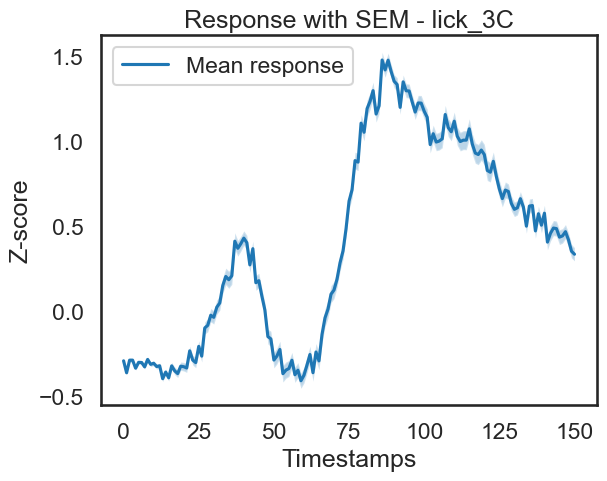

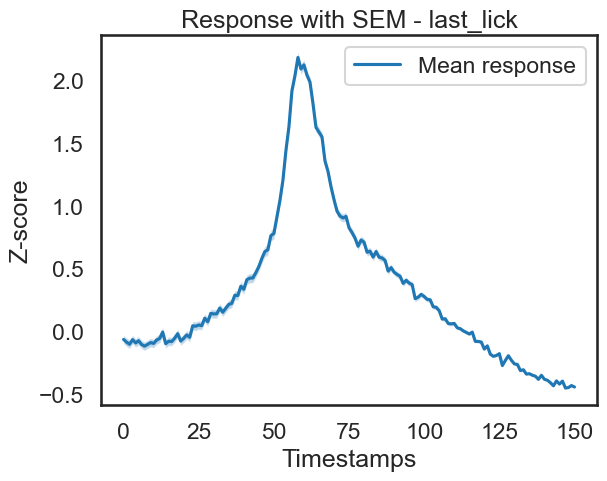

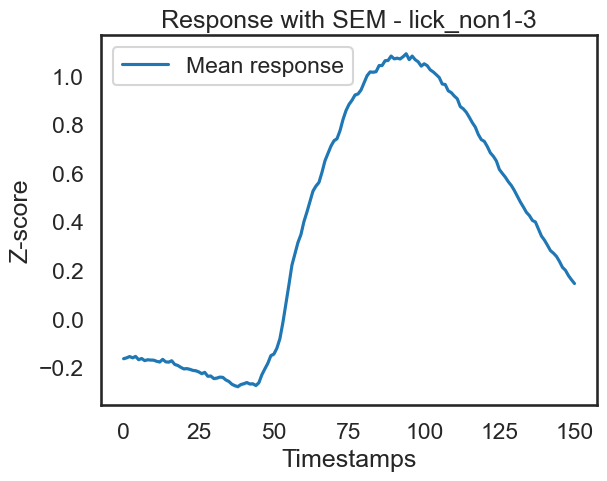

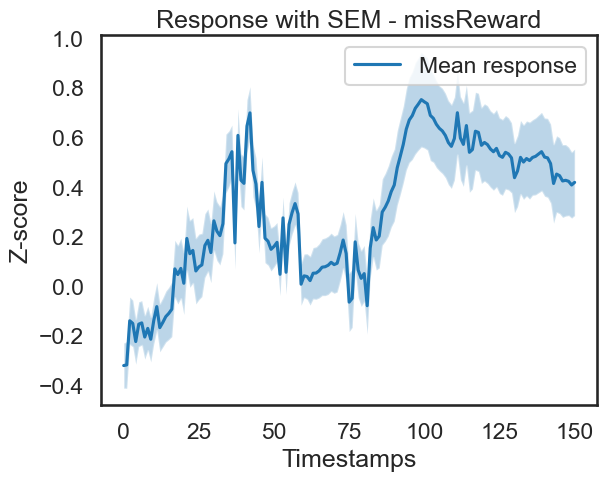

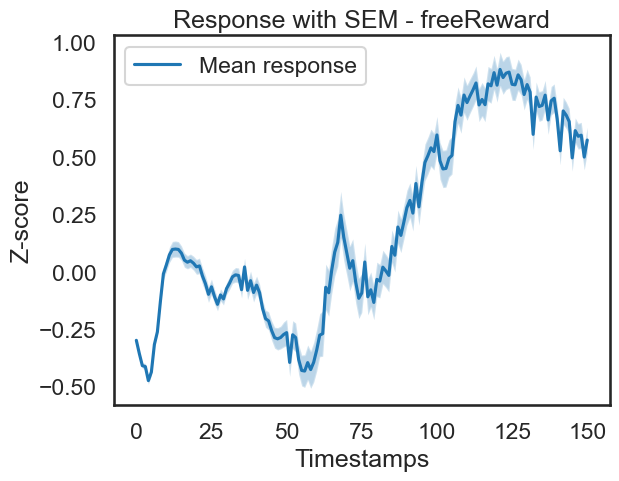

In [35]:
# Reconstruct your signal from your X-inputs
recon_dataStream = utils.align_reconstructed_dataStream(config, 
                                                        df_source, df_predictors_shift,
                                                         shifted_params, model)

# Create new directory for reconstructed data plots
save_dir = 'recon'
parent_dir = config['Project']['project_path'] + '/results/'
save_dir_path = os.path.join(parent_dir, save_dir)

# Check if the directory already exists
if not os.path.exists(save_dir_path):
    # Create the directory
    os.makedirs(save_dir_path)
    print("Directory created successfully!")
else:
    print("Directory already exists - will be overwritten!")
    #overwrite the directory
    shutil.copytree(save_dir_path, save_dir_path, dirs_exist_ok = True)

save_path = save_dir_path

# Plot reconstructed data
utils.plot_aligned_dataStream(recon_dataStream, config, save=True, save_path=save_path, reconstructed=True)

Directory created successfully!


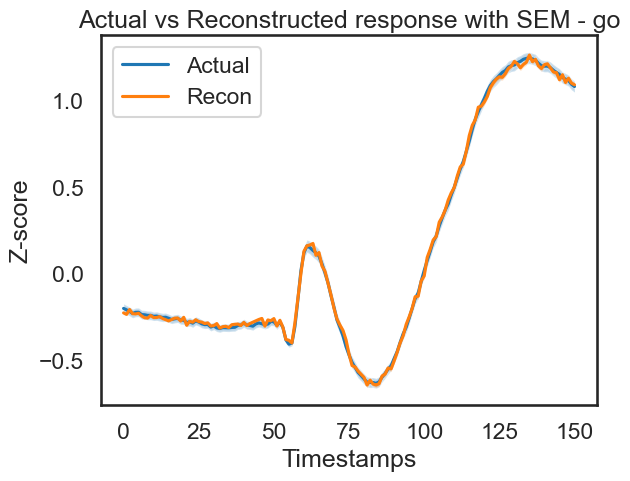

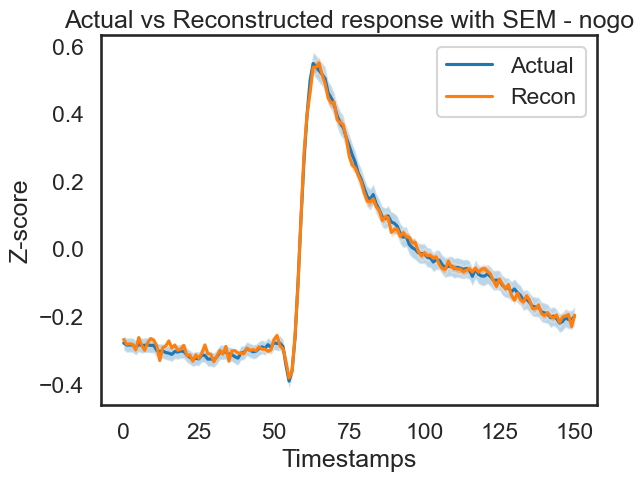

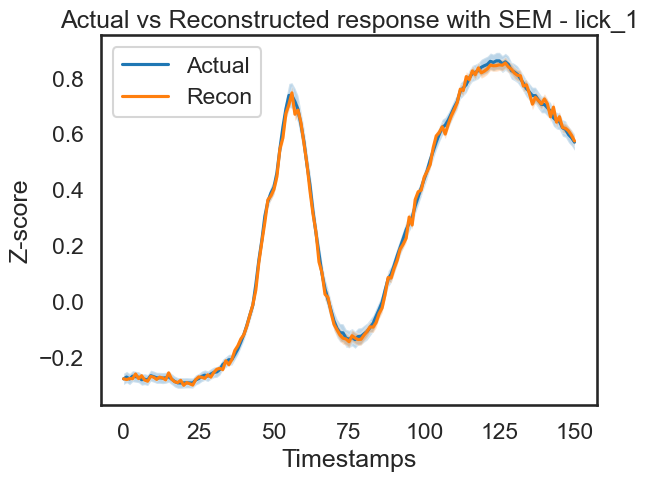

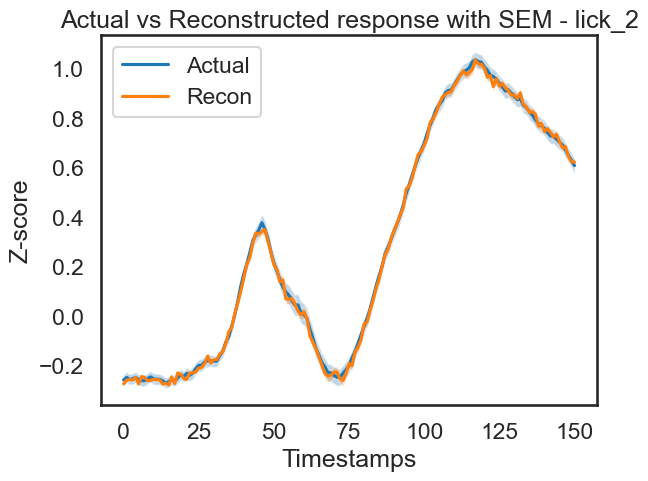

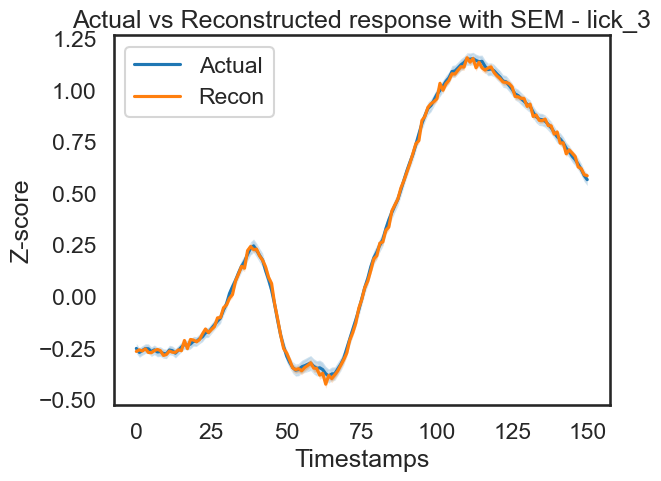

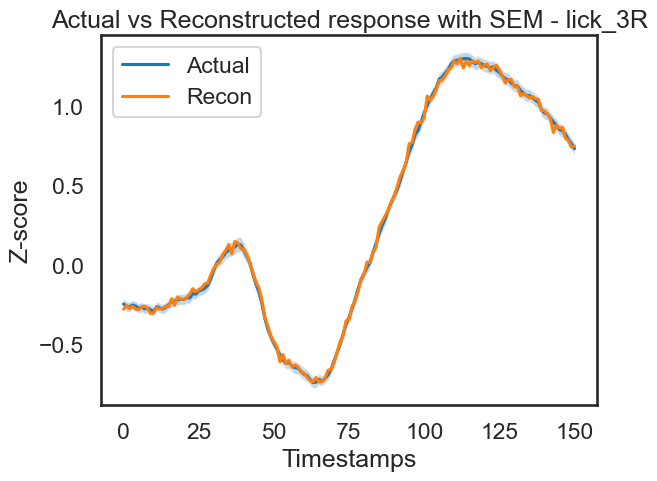

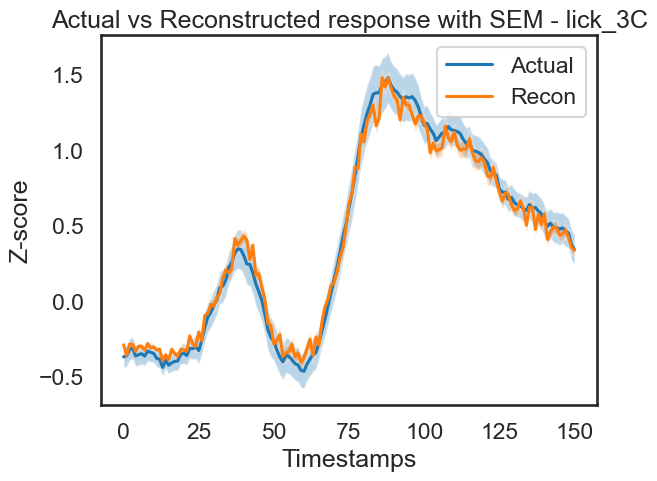

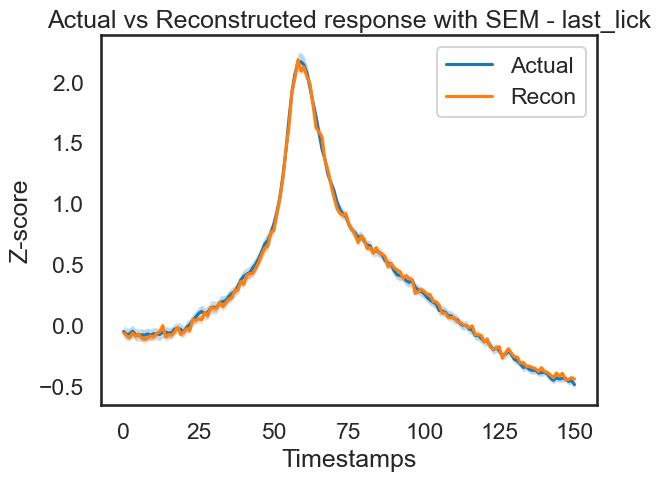

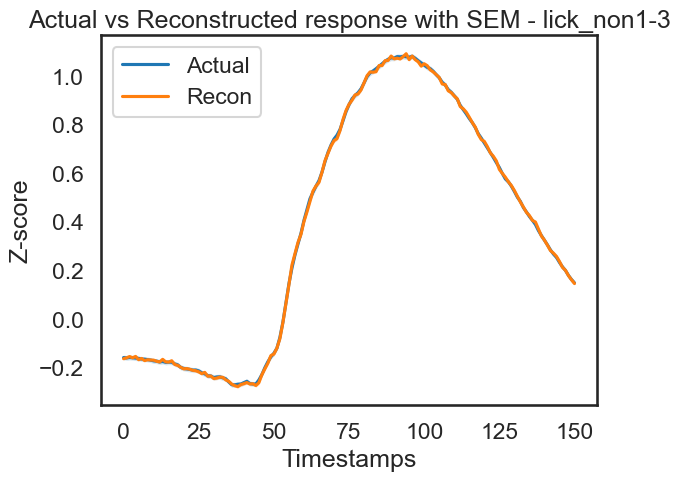

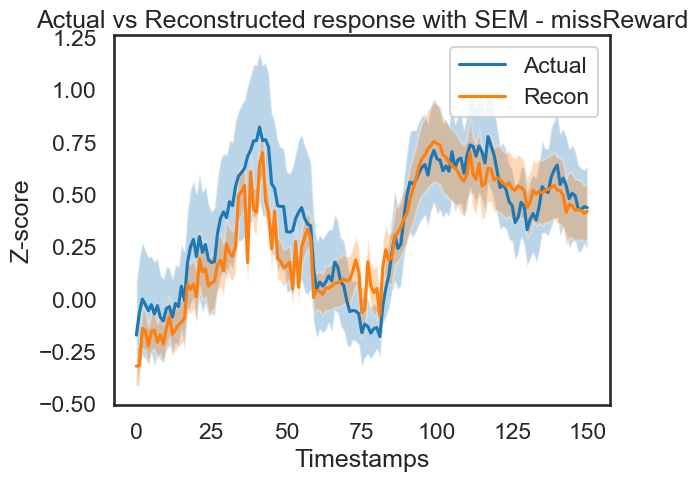

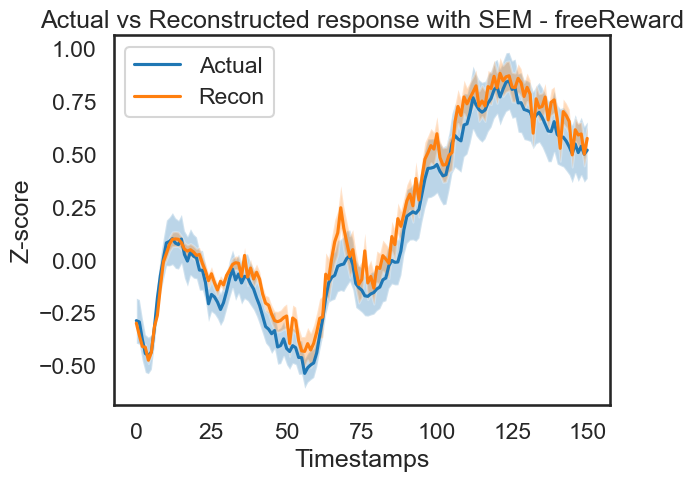

In [36]:
# Create new directory for actual vs reconstructed data plots
save_dir = 'actualVrecon'
parent_dir = config['Project']['project_path'] + '/results/'
save_dir_path = os.path.join(parent_dir, save_dir)

# Check if the directory already exists
if not os.path.exists(save_dir_path):
    # Create the directory
    os.makedirs(save_dir_path)
    print("Directory created successfully!")
else:
    print("Directory already exists - will be overwritten!")
    #overwrite the directory
    shutil.copytree(save_dir_path, save_dir_path, dirs_exist_ok = True)

save_path = save_dir_path

# Plot actual vs reconstructed
utils.plot_actual_v_reconstructed(config, aligned_dataStream, recon_dataStream, save=True, save_path=save_path)

## Additional validation: 

In addition to using k-folds cross-validation, you can also use the `leave_one_out_cross_val` method to validate your model. This method will leave one predictor out and fit the model on the remaining predictors. A `model_list` will be returned with the `model` and `predictions` for each left out predictor.

Fitting ElasticNet model...
Model fit complete
Predictor left out: go, Test Score: 0.2583990768518678, Train Score: 0.262123091842159. Adding to model list...
Fitting ElasticNet model...
Model fit complete
Predictor left out: nogo, Test Score: 0.26576185377711037, Train Score: 0.26926529459992843. Adding to model list...
Fitting ElasticNet model...
Model fit complete
Predictor left out: lick_1, Test Score: 0.23632672608318195, Train Score: 0.23938884760384616. Adding to model list...
Fitting ElasticNet model...
Model fit complete
Predictor left out: lick_2, Test Score: 0.26434052512478123, Train Score: 0.26732958076741675. Adding to model list...
Fitting ElasticNet model...
Model fit complete
Predictor left out: lick_3, Test Score: 0.27024552371546795, Train Score: 0.2731907112744256. Adding to model list...
Fitting ElasticNet model...
Model fit complete
Predictor left out: lick_3R, Test Score: 0.26942755554998743, Train Score: 0.27313839541074025. Adding to model list...
Fitting Elast

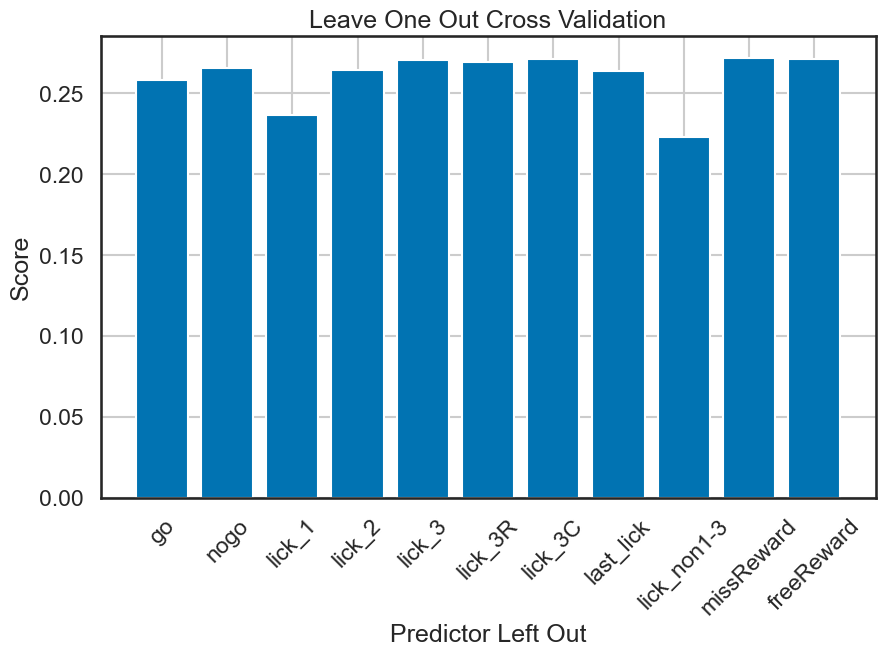

In [37]:
##NOTE: Cannot be sparse array for now

model_list = glm_fit.leave_one_out_cross_val(config, X_train, X_test, y_train, y_test, plot=True)

#Save your model_list
import pickle
LO_CV_path = (config['Project']['project_path'] + '/models/LO_CV_models.pkl')
with open(LO_CV_path, 'wb') as f:
        pickle.dump(model_list, f)

In [38]:
#save model_list to text file
model_list_save_path = config['Project']['project_path'] + '/results/LO_model_results'
with open(model_list_save_path, 'w') as f:
    print(model_list, file = f)

model_list

[{'predictors': ['nogo',
   'lick_1',
   'lick_2',
   'lick_3',
   'lick_3R',
   'lick_3C',
   'last_lick',
   'lick_non1-3',
   'missReward',
   'freeReward'],
  'model': ElasticNet(alpha=1e-05),
  'test_score': 0.2583990768518678,
  'train_score': 0.262123091842159,
  'beta': array([-0.00649631, -0.01298943, -0.01451009, ..., -0.        ,
         -0.        ,  0.0117876 ]),
  'intercept': -0.251877928417987,
  'predictor_left_out': 'go'},
 {'predictors': ['go',
   'lick_1',
   'lick_2',
   'lick_3',
   'lick_3R',
   'lick_3C',
   'last_lick',
   'lick_non1-3',
   'missReward',
   'freeReward'],
  'model': ElasticNet(alpha=1e-05),
  'test_score': 0.26576185377711037,
  'train_score': 0.26926529459992843,
  'beta': array([ 0.04835572,  0.01713846,  0.01864881, ..., -0.03843992,
         -0.        ,  0.        ]),
  'intercept': -0.2419344382088155,
  'predictor_left_out': 'nogo'},
 {'predictors': ['go',
   'nogo',
   'lick_2',
   'lick_3',
   'lick_3R',
   'lick_3C',
   'last_lick',


In [39]:
#predictors temp - removing any reward

X_train_temp = X_train[predictors_temp]
X_test_temp = X_test[predictors_temp]

model_temp, y_pred, score, beta, intercept = glm_fit.fit_glm(config, X_train_temp, X_test_temp, y_train, y_test)

#save model_list to text file
model_temp_save_path = config['Project']['project_path'] + '/results/leaveRewardOut_model_results'
with open(model_temp_save_path, 'w') as f:
    print(score, file = f)

score

Fitting ElasticNet model...
Model fit complete


0.2044603342013429

### Validating train and test performance:
The following can be used to assess train and test performance. 
This should be done after you have shifted the data, these cells are repeated below for clarity.

In [40]:
response_shift, df_predictors_shift, shifted_params = glm_fit.shift_predictors(config, df_source, sparsify=False)
print('Your dataframe was shifted using: {}'.format(shifted_params))

Your dataframe was shifted using: [('go', [-50, 100]), ('nogo', [-50, 100]), ('lick_1', [-50, 100]), ('lick_2', [-50, 100]), ('lick_3', [-50, 100]), ('lick_3R', [-50, 100]), ('lick_3C', [-50, 100]), ('last_lick', [-50, 100]), ('lick_non1-3', [-50, 100]), ('missReward', [-50, 100]), ('freeReward', [-50, 100])]


#### Below, you can fit the model with various train/test splits. This will *not* vary the test size, but instead, will vary the IDs used for training and testing.

In [41]:
#create multiple train-test splits and fit the model
#use AFTER you shift the data (NOT SPLIT) but BEFORE you fit the model

from sklearn.model_selection import ShuffleSplit

n_splits = 3 #set the number of splits you want here
test_size = 0.2 #train test ratio.. this is NO longer pulling from config file
shuffle_split = ShuffleSplit(n_splits=n_splits, test_size=test_size)

X = df_predictors_shift
y = response_shift

#create train-test splits
train_list = []
test_list = []
for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    train_list.append((X_train, y_train))
    test_list.append((X_test, y_test))


Fold 1:
Fitting ElasticNet model...
Model fit complete
Train score: 0.2768050812727193
Test score: 0.2677328180932598
Fold 2:
Fitting ElasticNet model...
Model fit complete
Train score: 0.2761782550768018
Test score: 0.2704025339390531
Fold 3:
Fitting ElasticNet model...
Model fit complete
Train score: 0.2758046891653496
Test score: 0.2717437660586597


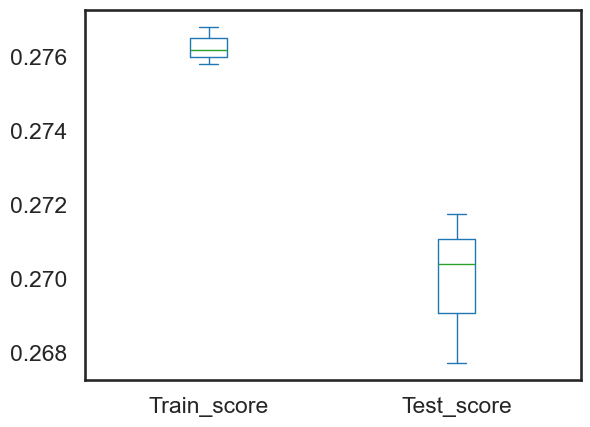

In [42]:
#run the model on each train-test split and plot
results = []
for i, (X_train, y_train) in enumerate(train_list):
    print(f"Fold {i+1}:")
    X_test, y_test = test_list[i]
    model, y_pred, score, beta, intercept = glm_fit.fit_glm(config, X_train, X_test, y_train, y_test)
    #calculate train score
    #fetch regression type and score metric from config
    regression_type = config['glm_params']['regression_type'].lower()
    score_metric = config['glm_params']['glm_keyword_args'][regression_type]['score_metric']
    y_train_pred = model.predict(X_train)
    if score_metric == 'r2':
        train_score = model.score(X_train, y_train)
    elif score_metric == 'mse':
        train_score = glm_fit.calc_mse(y_train, y_train_pred)
    print(f"Train score: {train_score}")
    print(f"Test score: {score}")
    results.append({'n_fold': i+1, 'Train_score': train_score, 'Test_score': score})

#plot boxplot of results with confidence intervals
results_df = pd.DataFrame(results)
results_df.plot(kind='box', y=['Train_score', 'Test_score'])

fig_save_path_png = os.path.join(project_dir, project_name, 'results\\trainAndTest.png')
fig_save_path_pdf = os.path.join(project_dir, project_name, 'results\\trainAndTest.pdf')
plt.savefig(fig_save_path_png)
plt.savefig(fig_save_path_pdf)

plt.show()

#### Below, you can fit the model with various train/test splits while doing the LOOCV analysis. This will *not* vary the test size, but instead, will vary the IDs used for training and testing. The results will be a dictionary with `n_folds`, `predictor_left_out`, and `scores`.

### Shuffle and run the LOOCV

In [43]:
#Run shuffle split cross validation on leave one out models
from sklearn.model_selection import ShuffleSplit

n_splits = 3 #set the number of splits you want here
test_size = 0.2 #train test ratio.. this is NO longer pulling from config file
shuffle_split = ShuffleSplit(n_splits=n_splits, test_size=test_size)

X = df_predictors_shift
y = response_shift

#create train-test splits
train_list = []
test_list = []
for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    train_list.append((X_train, y_train))
    test_list.append((X_test, y_test))

#run the model on each train-test split
results_LOOCV = []
for i, (X_train, y_train) in enumerate(train_list):
    print(f"Fold {i+1}:")
    X_test, y_test = test_list[i]
    model_list = glm_fit.leave_one_out_cross_val(config, X_train, X_test, y_train, y_test, plot=False)
    results_LOOCV.append({'n_fold': i+1, 'models': model_list})

Fold 1:
Fitting ElasticNet model...
Model fit complete
Predictor left out: go, Test Score: 0.2567886118557847, Train Score: 0.2625554563757626. Adding to model list...
Fitting ElasticNet model...
Model fit complete
Predictor left out: nogo, Test Score: 0.2639270597795421, Train Score: 0.26973157897999855. Adding to model list...
Fitting ElasticNet model...
Model fit complete
Predictor left out: lick_1, Test Score: 0.23295279162538152, Train Score: 0.24023215090611427. Adding to model list...
Fitting ElasticNet model...
Model fit complete
Predictor left out: lick_2, Test Score: 0.26296227480078804, Train Score: 0.267696369689731. Adding to model list...
Fitting ElasticNet model...
Model fit complete
Predictor left out: lick_3, Test Score: 0.2686941304161301, Train Score: 0.27358670872523605. Adding to model list...
Fitting ElasticNet model...
Model fit complete
Predictor left out: lick_3R, Test Score: 0.268015820555748, Train Score: 0.273492759339793. Adding to model list...
Fitting Ela

Processed fold 1
Processed fold 2
Processed fold 3


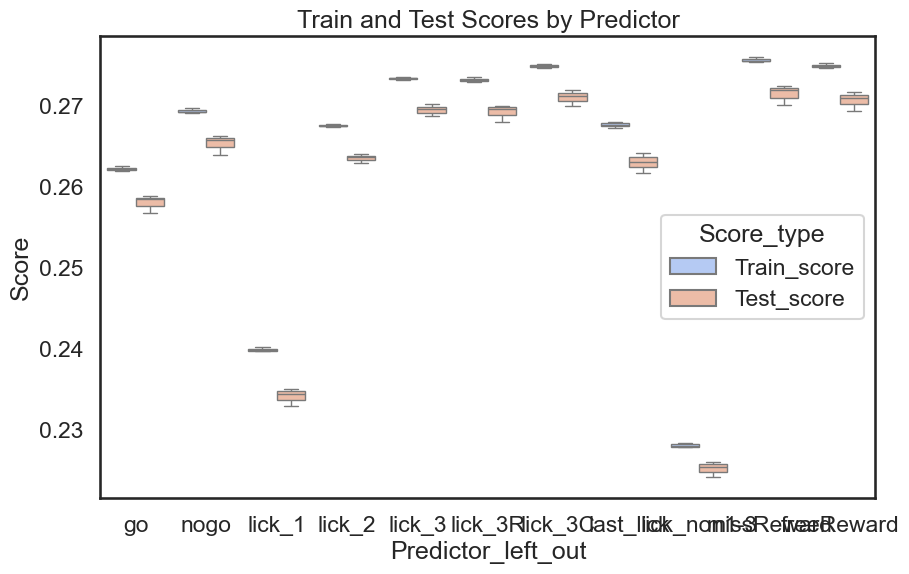

In [44]:
## FOR PLOTTING. WILL PARSE THE RESULTS AND PLOT THEM

results_by_predictor = {}

# Fetch test and train scores from each model in the model_list with fold number and predictor left out
for i, result in enumerate(results_LOOCV):
    print(f"Processed fold {i+1}")
    model_list = result['models']
    for j, model_dict in enumerate(model_list):
        train_score = model_dict['train_score']
        score = model_dict['test_score']
        predictor_left_out = model_dict['predictor_left_out']
        
        # Check if the predictor_left_out already exists in the dictionary
        if predictor_left_out not in results_by_predictor:
            results_by_predictor[predictor_left_out] = {'predictor_left_out': predictor_left_out, 'Fold_scores': []}
        
        # Append the scores for the current fold to the corresponding predictor_left_out entry in the dictionary
        results_by_predictor[predictor_left_out]['Fold_scores'].append({'n_fold': i+1, 'Test_score': score, 'Train_score': train_score})

#make boxplot of results by predictor for train and test scores
import seaborn as sns
all_scores = []

# Iterate through results_by_predictor to populate all_scores for easy plotting
for key, value in results_by_predictor.items():
    predictor = key
    fold_scores = value['Fold_scores']
    for fold_score in fold_scores:
        train_score = fold_score['Train_score']
        test_score = fold_score['Test_score']
        all_scores.append({'Predictor_left_out': predictor, 'Score_type': 'Train_score', 'Score': train_score})
        all_scores.append({'Predictor_left_out': predictor, 'Score_type': 'Test_score', 'Score': test_score})

# Convert the list of dictionaries to a dataframe
all_scores_df = pd.DataFrame(all_scores)

# Plotting the box plot
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(data=all_scores_df, x='Predictor_left_out', y='Score', hue='Score_type', palette='coolwarm')
boxplot.set_title('Train and Test Scores by Predictor')

fig_save_path_png = os.path.join(project_dir, project_name, 'results\\trainAndTestByPredictor.png')
fig_save_path_pdf = os.path.join(project_dir, project_name, 'results\\trainAndTestByPredictor.pdf')
plt.savefig(fig_save_path_png)
plt.savefig(fig_save_path_pdf)

plt.show()